In [1]:
# Create a new notebook in Google Colab
# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

# Create a project folder
!mkdir -p /content/drive/MyDrive/crater_detection

# Install required packages
!pip install ultralytics
!pip install opencv-python-headless
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install kaggle

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu1

In [2]:
# Upload your kaggle.json API key
from google.colab import files
uploaded = files.upload()  # Upload your kaggle.json

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Search for planetary/crater datasets
!kaggle datasets list -s "mars crater"

# Download a specific dataset (replace with your chosen dataset)
!kaggle datasets download -d lincolnzh/martianlunar-crater-detection-dataset
!unzip martianlunar-crater-detection-dataset.zip -d /content/dataset

Saving kaggle.json to kaggle.json
ref                                                             title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
codebreaker619/mars-crater-study-dataset                        Mars Crater Study Dataset                             4068517  2021-01-11 06:25:49.220000            620         34  0.9411765        
lincolnzh/martianlunar-crater-detection-dataset                 Martian/Lunar Crater Detection Dataset               77604628  2022-02-15 00:18:51.217000           2721         29  0.9375           
docxian/mars-maps                                               Mars Maps                                             2616710  2021-01-11 19:43:34.940000             68  

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import glob

# Create YOLOv11 dataset structure
!mkdir -p /content/yolo_dataset/train/images
!mkdir -p /content/yolo_dataset/train/labels
!mkdir -p /content/yolo_dataset/val/images
!mkdir -p /content/yolo_dataset/val/labels

# Check dataset structure
!ls -la /content/dataset

# Find all image files
image_files = []
for ext in ['*.jpg', '*.png', '*.jpeg']:
    image_files.extend(glob.glob(f'/content/dataset/**/{ext}', recursive=True))

print(f"Found {len(image_files)} image files")

if len(image_files) == 0:
    print("No images found! Please check dataset structure.")
    # Display the dataset structure
    !find /content/dataset -type f | sort
else:
    # Split into train/val (80/20)
    train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

    print(f"Training images: {len(train_files)}")
    print(f"Validation images: {len(val_files)}")

    # Function to find label file for an image
    def find_label_file(img_path):
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        # Try common label locations
        possible_paths = [
            os.path.join(os.path.dirname(img_path).replace('images', 'labels'), f"{base_name}.txt"),
            os.path.join(os.path.dirname(os.path.dirname(img_path)), 'labels', f"{base_name}.txt"),
            os.path.join('/content/dataset/labels', f"{base_name}.txt")
        ]

        for path in possible_paths:
            if os.path.exists(path):
                return path
        return None

    # Copy files to YOLO structure
    for idx, img_path in enumerate(train_files):
        # Get filename
        filename = os.path.basename(img_path)

        # Copy image
        dest_path = f'/content/yolo_dataset/train/images/{filename}'
        shutil.copy(img_path, dest_path)

        # Find and copy label if exists
        label_path = find_label_file(img_path)
        if label_path:
            label_name = os.path.basename(label_path)
            shutil.copy(label_path, f'/content/yolo_dataset/train/labels/{label_name}')

        # Progress update
        if idx % 100 == 0:
            print(f"Processed {idx}/{len(train_files)} training images")

    for idx, img_path in enumerate(val_files):
        # Get filename
        filename = os.path.basename(img_path)

        # Copy image
        dest_path = f'/content/yolo_dataset/val/images/{filename}'
        shutil.copy(img_path, dest_path)

        # Find and copy label if exists
        label_path = find_label_file(img_path)
        if label_path:
            label_name = os.path.basename(label_path)
            shutil.copy(label_path, f'/content/yolo_dataset/val/labels/{label_name}')

        # Progress update
        if idx % 50 == 0:
            print(f"Processed {idx}/{len(val_files)} validation images")

    # Count files in each directory
    print("\nDataset Structure:")
    print(f"Train Images: {len(os.listdir('/content/yolo_dataset/train/images'))}")
    print(f"Train Labels: {len(os.listdir('/content/yolo_dataset/train/labels'))}")
    print(f"Val Images: {len(os.listdir('/content/yolo_dataset/val/images'))}")
    print(f"Val Labels: {len(os.listdir('/content/yolo_dataset/val/labels'))}")

total 69520
drwxr-xr-x 3 root root     4096 Aug  5 16:22 .
drwxr-xr-x 1 root root     4096 Aug  5 16:23 ..
-rw-r--r-- 1 root root 71169925 Feb 15  2022 best.pt
drwxr-xr-x 5 root root     4096 Aug  5 16:22 craters
Found 143 image files
Training images: 114
Validation images: 29
Processed 0/114 training images
Processed 100/114 training images
Processed 0/29 validation images

Dataset Structure:
Train Images: 114
Train Labels: 114
Val Images: 29
Val Labels: 29


In [4]:
# If your dataset doesn't have labels, create synthetic ones
# Only run this if labels are missing

def create_synthetic_labels():
    # Check if we have labels
    train_images = len(os.listdir('/content/yolo_dataset/train/images'))
    train_labels = len(os.listdir('/content/yolo_dataset/train/labels'))

    if train_labels < train_images * 0.5:  # If less than 50% of images have labels
        print("Creating synthetic labels for missing images...")

        # For training images
        for img_file in os.listdir('/content/yolo_dataset/train/images'):
            base_name = os.path.splitext(img_file)[0]
            label_file = f'/content/yolo_dataset/train/labels/{base_name}.txt'

            if not os.path.exists(label_file):
                # Create a simple label (center box covering 50% of image)
                with open(label_file, 'w') as f:
                    f.write("0 0.5 0.5 0.5 0.5")  # class_id x_center y_center width height

        # For validation images
        for img_file in os.listdir('/content/yolo_dataset/val/images'):
            base_name = os.path.splitext(img_file)[0]
            label_file = f'/content/yolo_dataset/val/labels/{base_name}.txt'

            if not os.path.exists(label_file):
                # Create a simple label (center box covering 50% of image)
                with open(label_file, 'w') as f:
                    f.write("0 0.5 0.5 0.5 0.5")  # class_id x_center y_center width height

        print("Synthetic labels created.")
        print(f"Train Labels: {len(os.listdir('/content/yolo_dataset/train/labels'))}")
        print(f"Val Labels: {len(os.listdir('/content/yolo_dataset/val/labels'))}")

# Call the function if needed
create_synthetic_labels()

In [5]:
# Create dataset.yaml for YOLOv11
with open('/content/dataset.yaml', 'w') as f:
    f.write("train: /content/yolo_dataset/train/images\n")
    f.write("val: /content/yolo_dataset/val/images\n")
    f.write("nc: 1\n")  # Number of classes (update if needed)
    f.write("names: ['crater']\n")  # Class names (update if needed)

# Verify the content
!cat /content/dataset.yaml

# Verify that images exist at the specified paths
!ls -la /content/yolo_dataset/train/images | head -5
!ls -la /content/yolo_dataset/val/images | head -5

train: /content/yolo_dataset/train/images
val: /content/yolo_dataset/val/images
nc: 1
names: ['crater']
total 9436
drwxr-xr-x 2 root root  12288 Aug  5 16:23 .
drwxr-xr-x 4 root root   4096 Aug  5 16:23 ..
-rw-r--r-- 1 root root  91828 Aug  5 16:23 010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg
-rw-r--r-- 1 root root  69008 Aug  5 16:23 011_png.rf.8ac312b4898f0106d10b76952a55d237.jpg
total 2476
drwxr-xr-x 2 root root   4096 Aug  5 16:23 .
drwxr-xr-x 4 root root   4096 Aug  5 16:23 ..
-rw-r--r-- 1 root root  69273 Aug  5 16:23 013_png.rf.ee44d5aa33fd33a1ed62ae233180f505.jpg
-rw-r--r-- 1 root root  88454 Aug  5 16:23 02_png.rf.610687947e4c92f77e6462104ec4b924.jpg


In [7]:
from ultralytics import YOLO

# Initialize a new YOLOv11 model (choose size based on your needs)
# 'n' = nano (smallest/fastest), 's' = small, 'm' = medium, 'l' = large, 'x' = xlarge (most accurate)
model = YOLO('yolo11n.pt')  # Start with pre-trained YOLOv11 nano model

# Verify YAML path exists
import os
yaml_path = '/content/dataset.yaml'
print(f"YAML file exists: {os.path.exists(yaml_path)}")

# Train the YOLOv11 model
results = model.train(
    data=yaml_path,
    epochs=100,  # Adjust based on your needs
    imgsz=640,  # Image size
    batch=16,   # Batch size (adjust based on GPU memory)
    device=0,   # Use GPU
    project='/content/drive/MyDrive/crater_detection',
    name='yolo11_crater_detection',
    save=True,
    verbose=True,
    patience=20,  # Early stopping patience
    save_period=5,  # Save checkpoint every 5 epochs
)

print("Training completed!")

YAML file exists: True
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_crater_detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, p

train: Scanning /content/yolo_dataset/train/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 618.5±405.3 MB/s, size: 87.1 KB)


val: Scanning /content/yolo_dataset/val/labels.cache... 29 images, 1 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/crater_detection/yolo11_crater_detection2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/crater_detection/yolo11_crater_detection2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.71G      1.903      3.329      1.518         18        640: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         29        241     0.0126      0.456     0.0217    0.00983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.86G      1.568      2.856      1.354         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         29        241     0.0192      0.693      0.181     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.86G      1.523      1.999      1.228          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         29        241     0.0178      0.643      0.146       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.86G      1.551      1.704      1.262         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         29        241     0.0215      0.776     0.0953     0.0564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.86G       1.48      1.799      1.253         14        640: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29        241     0.0197       0.71     0.0849     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.86G      1.433      1.592      1.258         20        640: 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         29        241      0.541     0.0705     0.0898     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.86G      1.433      1.604      1.284         16        640: 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         29        241     0.0924     0.0664      0.042     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.86G      1.452      1.507      1.266         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         29        241      0.277      0.112      0.107      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.86G      1.473      1.447      1.221         32        640: 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29        241      0.109     0.0871     0.0579     0.0269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.86G      1.455      1.481      1.244         30        640: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29        241      0.267      0.163      0.122     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.86G      1.437      1.371      1.257         20        640: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         29        241      0.422      0.237      0.303      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.86G      1.376       1.42      1.253         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         29        241      0.496      0.361      0.365      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.86G      1.357      1.318      1.218         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         29        241      0.442      0.332       0.33      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.86G      1.375      1.389      1.241          7        640: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         29        241      0.319      0.386       0.29      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.86G      1.423      1.413      1.247         17        640: 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         29        241      0.449      0.452      0.433      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.86G      1.484      1.344      1.232         24        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         29        241      0.437      0.544      0.445      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.86G      1.513      1.491      1.245          7        640: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         29        241      0.478      0.506      0.492      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.88G      1.303      1.278      1.186         16        640: 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         29        241      0.527      0.456      0.483      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.88G      1.356      1.209      1.197         23        640: 100%|██████████| 8/8 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29        241      0.501      0.465      0.389      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.88G      1.472      1.295      1.227         10        640: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         29        241      0.436      0.444      0.377       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.88G      1.382      1.247      1.214         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         29        241        0.5      0.448      0.427      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.88G      1.369      1.189        1.2         27        640: 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         29        241      0.607      0.436      0.511      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.88G      1.342      1.191      1.193         15        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         29        241      0.511      0.477       0.48      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.88G       1.31      1.224      1.203          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         29        241      0.536      0.527      0.533       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.88G      1.355      1.237      1.156         16        640: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         29        241       0.65      0.452      0.537      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.88G       1.37      1.287      1.214         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         29        241      0.658      0.481      0.565       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.88G      1.447      1.227      1.177         13        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         29        241      0.549      0.535      0.554      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.88G      1.322      1.152      1.175         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         29        241      0.557      0.479      0.545      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.88G      1.331      1.138      1.194         13        640: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         29        241      0.569      0.427      0.494      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.88G      1.364      1.134      1.166         23        640: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29        241      0.532      0.443      0.482      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.88G      1.231      1.155      1.154         28        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         29        241      0.493      0.485      0.454      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.88G       1.32      1.168      1.154         24        640: 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         29        241      0.549      0.506      0.512      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.88G      1.336      1.113       1.17         36        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         29        241      0.558      0.506      0.528       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.88G       1.37      1.117      1.208         11        640: 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         29        241       0.56      0.524      0.536      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.88G      1.292      1.149      1.189         11        640: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         29        241      0.529       0.54      0.562       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.88G      1.277      1.011      1.151         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         29        241       0.58      0.465      0.488      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.88G      1.293      1.336      1.189          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         29        241      0.479      0.552      0.462      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.88G      1.221      1.067      1.106         25        640: 100%|██████████| 8/8 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         29        241      0.402       0.61      0.419      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.88G      1.218      1.047      1.155          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         29        241      0.487      0.568      0.508      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.88G      1.226      1.028      1.118         30        640: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         29        241      0.577      0.475      0.528      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.88G      1.289      1.057      1.178         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         29        241       0.55      0.452      0.508      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.88G      1.223     0.9946      1.109         37        640: 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         29        241      0.562      0.473      0.499      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.88G      1.204     0.9611      1.085         28        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         29        241      0.492       0.56      0.508      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.88G      1.315      1.045      1.137         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         29        241      0.483      0.539      0.478      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.88G      1.304     0.9879      1.133         36        640: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         29        241      0.576      0.535      0.576      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.88G      1.248     0.9628      1.132         36        640: 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         29        241      0.539      0.602      0.575       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.88G      1.324      1.085      1.167          6        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         29        241      0.555       0.49      0.516      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.88G      1.289      1.175      1.207          5        640: 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         29        241      0.548      0.492      0.503       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.88G      1.208     0.9446      1.161         18        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         29        241      0.524       0.49       0.46      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.88G      1.235     0.9735      1.127         15        640: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         29        241      0.549      0.495      0.494      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.88G      1.277     0.9851      1.116         18        640: 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         29        241      0.527      0.519      0.532      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.88G      1.214     0.9555      1.128         21        640: 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         29        241      0.549      0.531      0.538      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.88G      1.199     0.9518      1.128          9        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         29        241      0.545      0.511      0.531      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.88G       1.18     0.8892      1.115         20        640: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         29        241      0.587       0.56      0.561      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.88G      1.139     0.8752       1.09         19        640: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         29        241      0.557       0.58       0.55       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.88G      1.193     0.9433      1.088         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         29        241      0.595       0.56      0.539      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.88G        1.2     0.9229      1.114         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         29        241      0.551      0.598      0.543      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.88G      1.135     0.8718      1.088         15        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         29        241      0.656       0.53      0.592      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.88G      1.202     0.8902      1.107         25        640: 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         29        241      0.617      0.588      0.604      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.88G       1.19     0.8955        1.1         50        640: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         29        241      0.661      0.564      0.604      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.88G       1.19     0.9043      1.072         24        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         29        241      0.612       0.61      0.602      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.88G      1.196     0.9009      1.108         24        640: 100%|██████████| 8/8 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         29        241      0.555      0.627       0.56      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.88G      1.131     0.8458      1.083         10        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         29        241       0.56      0.548      0.518      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.88G      1.121     0.8732      1.126         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         29        241      0.576       0.56      0.534      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.88G       1.11     0.8592      1.062         20        640: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         29        241      0.567      0.575      0.551      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.88G      1.099     0.8257      1.048         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         29        241      0.548      0.578       0.54      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.88G      1.123     0.8676      1.063         58        640: 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         29        241      0.536      0.573      0.494      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.88G      1.119     0.8162       1.07         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         29        241      0.525      0.614       0.48      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.88G       1.11     0.8153      1.076         23        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         29        241      0.565      0.564       0.51      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.88G      1.118     0.8875      1.059         19        640: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         29        241      0.527      0.598      0.546      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.88G      1.126     0.8488      1.066         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         29        241      0.553      0.515      0.506      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.88G      1.088     0.7674      1.046         13        640: 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         29        241      0.559      0.535      0.501      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.88G      1.045     0.8355      1.058         14        640: 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         29        241      0.554      0.539      0.514       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.88G      1.096     0.7723       1.06         24        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         29        241      0.579       0.56      0.548      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.88G      1.079     0.8141      1.056         16        640: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         29        241      0.578      0.568       0.55      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.88G      1.103     0.8242       1.08         12        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         29        241      0.546      0.619       0.53       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.88G      1.083     0.7996      1.058          8        640: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         29        241       0.59      0.577      0.535      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.88G      1.082     0.7845      1.048         44        640: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         29        241      0.563       0.56      0.515      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.88G      1.091       0.79       1.08         17        640: 100%|██████████| 8/8 [00:01<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         29        241      0.603      0.535      0.511      0.235
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 59, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



79 epochs completed in 0.062 hours.
Optimizer stripped from /content/drive/MyDrive/crater_detection/yolo11_crater_detection2/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/crater_detection/yolo11_crater_detection2/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/crater_detection/yolo11_crater_detection2/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


                   all         29        241      0.625      0.573      0.605      0.309
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /content/drive/MyDrive/crater_detection/yolo11_crater_detection2
Training completed!


In [8]:
# Load the best trained model
best_model = YOLO('/content/drive/MyDrive/crater_detection/yolo11_crater_detection/weights/best.pt')

# Validate the model
validation_results = best_model.val()

# Print validation metrics
print("Validation Results:")
print(f"mAP50: {validation_results.box.map50}")
print(f"mAP50-95: {validation_results.box.map}")
print(f"Precision: {validation_results.box.mp}")
print(f"Recall: {validation_results.box.mr}")

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1271.5±289.4 MB/s, size: 78.3 KB)


val: Scanning /content/yolo_dataset/val/labels.cache... 29 images, 1 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


                   all         29        241      0.562      0.465      0.512      0.251
Speed: 0.3ms preprocess, 20.4ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to runs/detect/val
Validation Results:
mAP50: 0.5124043140341076
mAP50-95: 0.25126395684359737
Precision: 0.5622511278958324
Recall: 0.46473029045643155



image 1/1 /content/yolo_dataset/val/images/mars_crater--101-_jpg.rf.8f4eb1c77ab9e64d2fd691a6e0fcd3ec.jpg: 640x640 1 crater, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

Results for mars_crater--101-_jpg.rf.8f4eb1c77ab9e64d2fd691a6e0fcd3ec.jpg:


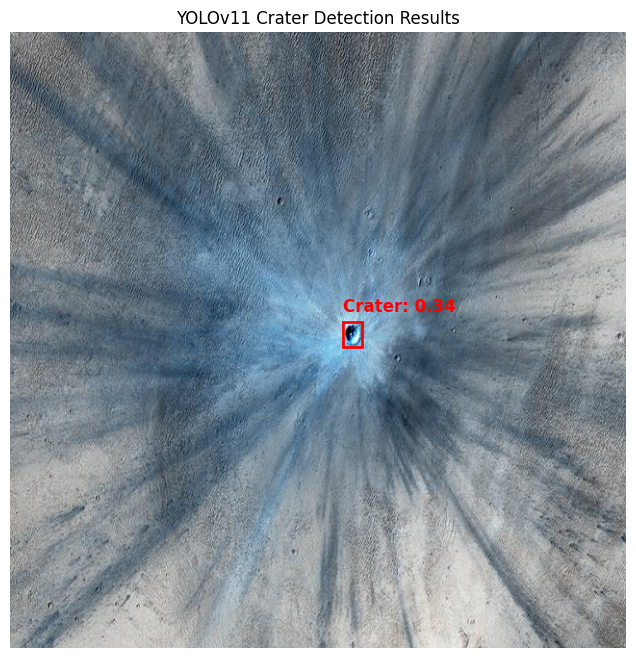

Number of craters detected: 1
Confidence scores: [    0.34221]

image 1/1 /content/yolo_dataset/val/images/mars_crater--92-_jpg.rf.608e45488b76786c69755a901c1b73c9.jpg: 640x640 5 craters, 13.7ms
Speed: 2.9ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

Results for mars_crater--92-_jpg.rf.608e45488b76786c69755a901c1b73c9.jpg:


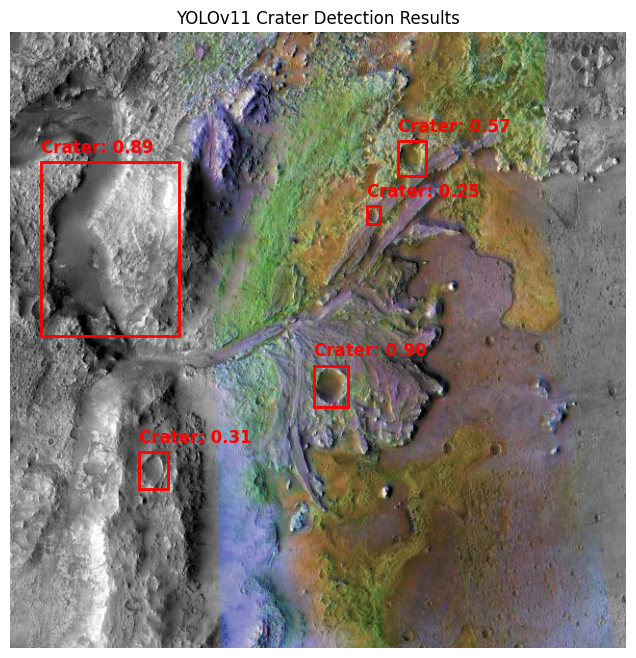

Number of craters detected: 5
Confidence scores: [     0.9013     0.88856     0.57023     0.31015     0.25249]

image 1/1 /content/yolo_dataset/val/images/mars_crater--96-_jpg.rf.6dca8e5264f81785f8d718f92f9e4475.jpg: 640x640 8 craters, 13.2ms
Speed: 2.6ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

Results for mars_crater--96-_jpg.rf.6dca8e5264f81785f8d718f92f9e4475.jpg:


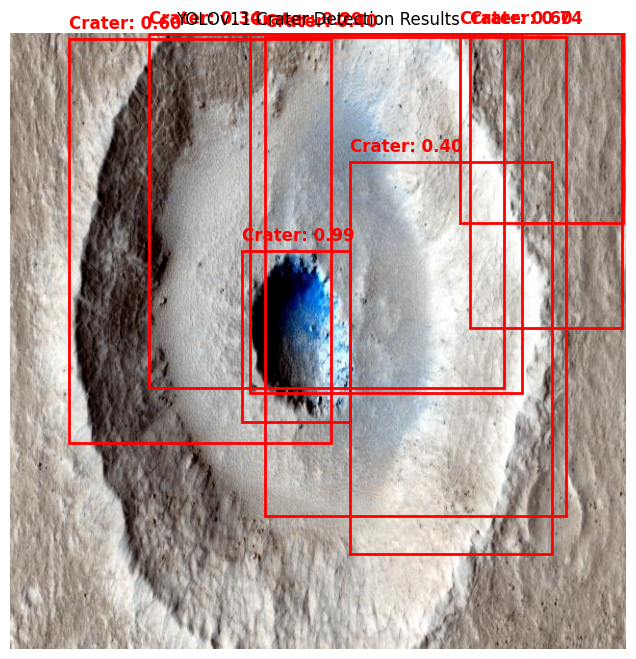

Number of craters detected: 8
Confidence scores: [    0.99075     0.73656     0.60347     0.59768     0.40007     0.39595     0.33956      0.2935]

image 1/1 /content/yolo_dataset/val/images/mars_crater--17-_jpg.rf.c051d4c804f2fed2aa32999cc9fd0b48.jpg: 640x640 1 crater, 17.7ms
Speed: 10.1ms preprocess, 17.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

Results for mars_crater--17-_jpg.rf.c051d4c804f2fed2aa32999cc9fd0b48.jpg:


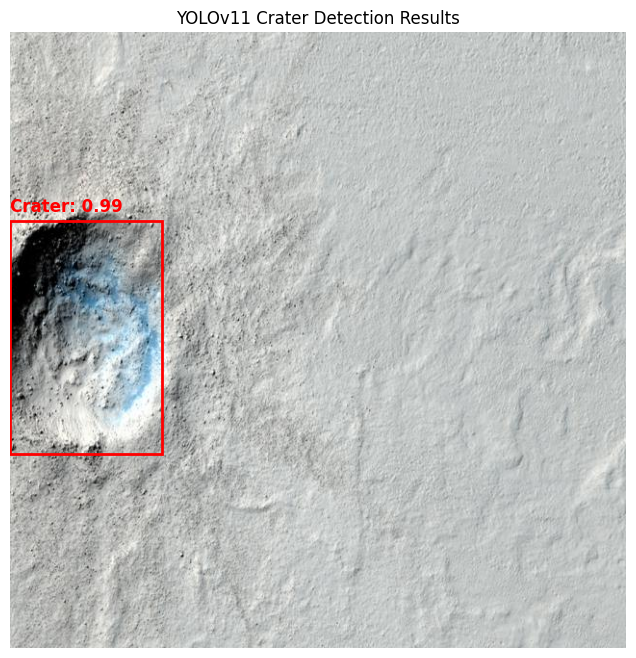

Number of craters detected: 1
Confidence scores: [    0.99034]

image 1/1 /content/yolo_dataset/val/images/mars_crater--91-_jpg.rf.9203caee622cf671580b91536e36e7e2.jpg: 640x640 5 craters, 13.9ms
Speed: 3.1ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

Results for mars_crater--91-_jpg.rf.9203caee622cf671580b91536e36e7e2.jpg:


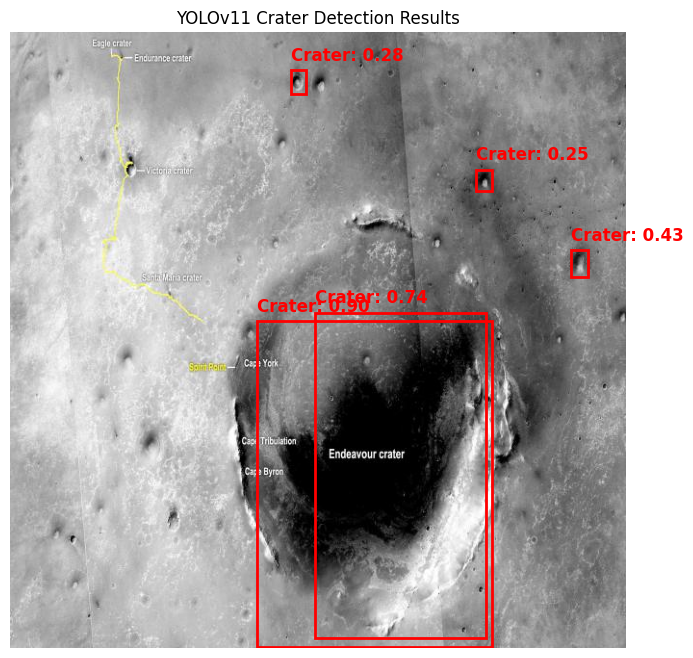

Number of craters detected: 5
Confidence scores: [    0.90045     0.73609     0.42593     0.27715     0.25446]


In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Function to display results
def display_results(image_path, results):
    # Read image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)

    # Draw bounding boxes
    if len(results) > 0 and results[0].boxes is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confidences = results[0].boxes.conf.cpu().numpy()

        for box, conf in zip(boxes, confidences):
            x1, y1, x2, y2 = box
            # Draw rectangle
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Add confidence text
            plt.text(x1, y1-10, f'Crater: {conf:.2f}',
                    color='red', fontsize=12, weight='bold')

    plt.title('YOLOv11 Crater Detection Results')
    plt.axis('off')
    plt.show()

# Test on a few validation images
val_images = os.listdir('/content/yolo_dataset/val/images')[:5]

for img_name in val_images:
    img_path = f'/content/yolo_dataset/val/images/{img_name}'

    # Run inference
    results = best_model(img_path)

    # Display results
    print(f"\nResults for {img_name}:")
    display_results(img_path, results)

    # Print detection details
    if len(results) > 0 and results[0].boxes is not None:
        num_detections = len(results[0].boxes)
        confidences = results[0].boxes.conf.cpu().numpy()
        print(f"Number of craters detected: {num_detections}")
        if num_detections > 0:
            print(f"Confidence scores: {confidences}")
    else:
        print("No craters detected")

In [10]:
# Export the trained model to different formats
try:
    # Export to ONNX format for deployment
    best_model.export(format='onnx')
    print("Model exported to ONNX format successfully!")

    # Export to TensorRT (if available)
    # best_model.export(format='engine')

    # Export to CoreML (for iOS deployment)
    # best_model.export(format='coreml')

except Exception as e:
    print(f"Export failed: {e}")

# Save model summary
print("\nModel Summary:")
print(f"Model architecture: YOLOv11n")
print(f"Parameters: {sum(p.numel() for p in best_model.model.parameters())}")
print(f"Model size: {os.path.getsize('/content/drive/MyDrive/crater_detection/yolo11_crater_detection/weights/best.pt') / (1024*1024):.2f} MB")

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/drive/MyDrive/crater_detection/yolo11_crater_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 7.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.62...
ONNX: export success ✅ 9.9s, saved as '/content/drive/MyDrive/crater_detection/yolo11_crater_detection/weights/best.onnx' (10.1 MB)

Export complete (10.3s)
Results saved to /content/drive/MyDrive/crater_detection/yolo11_crater_detect

In [12]:
# Force TensorFlow to use CPU for this particular task
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU for TensorFlow

import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV2  # Lighter model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
import pickle

# Create directories for validation dataset
!mkdir -p /content/validation_data/planetary
!mkdir -p /content/validation_data/non_planetary

# Copy some crater images to use as planetary examples
import glob
planetary_images = glob.glob("/content/yolo_dataset/train/images/*")[:30]
for i, img_path in enumerate(planetary_images):
    shutil.copy(img_path, f'/content/validation_data/planetary/planet_{i}.jpg')

print("Please upload some non-planetary images (buildings, people, etc.):")
from google.colab import files
uploaded = files.upload()  # Upload non-planetary images
for filename in uploaded.keys():
    shutil.copy(filename, f'/content/validation_data/non_planetary/{filename}')

# Use a lighter model and ensure it runs on CPU
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    try:
        # Error handling for image loading
        try:
            img = image.load_img(img_path, target_size=(224, 224))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Use with statement to ensure proper cleanup
        with tf.device('/cpu:0'):
            features = base_model.predict(x, verbose=0)

        return features.flatten()
    except Exception as e:
        print(f"Feature extraction error for {img_path}: {e}")
        return None

# Extract features from all images with error handling
features = []
labels = []

# Planetary images (positive)
for img_file in os.listdir('/content/validation_data/planetary'):
    if img_file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join('/content/validation_data/planetary', img_file)
        feat = extract_features(img_path)
        if feat is not None:
            features.append(feat)
            labels.append(1)  # 1 for planetary

# Non-planetary images (negative)
for img_file in os.listdir('/content/validation_data/non_planetary'):
    if img_file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join('/content/validation_data/non_planetary', img_file)
        feat = extract_features(img_path)
        if feat is not None:
            features.append(feat)
            labels.append(0)  # 0 for non-planetary

# Only proceed if we have sufficient data
if len(features) > 5:  # At least a few examples of each class
    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Split into train/test
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train a classifier
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)

    # Evaluate
    from sklearn.metrics import classification_report, accuracy_score
    y_pred = classifier.predict(X_test)
    print(f"Classifier Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

    # Save the classifier
    with open('/content/planetary_classifier.pkl', 'wb') as f:
        pickle.dump(classifier, f)
else:
    print("Not enough valid images found for classifier training.")

    # Create a simple fallback classifier that always predicts "planetary"
    class FallbackClassifier:
        def predict(self, X):
            return np.ones(len(X))

        def predict_proba(self, X):
            probs = np.zeros((len(X), 2))
            probs[:, 1] = 1.0  # Always predict class 1 (planetary)
            return probs

    classifier = FallbackClassifier()
    with open('/content/planetary_classifier.pkl', 'wb') as f:
        pickle.dump(classifier, f)
    print("Created fallback classifier that always predicts 'planetary'")

Please upload some non-planetary images (buildings, people, etc.):


Saving test.JPG to test.JPG
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature extraction error for /content/validation_data/planetary/planet_24.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_10.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_9.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_13.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_7.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_22.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_21.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_15.jpg: name 'tf' is not defined
Feature extraction error for /content/validation_data/planetary/planet_14.jpg: name 'tf' is n

In [13]:
def is_planetary_surface(image_path, classifier, feature_extractor=extract_features):
    """Check if an image is a planetary surface"""
    # Handle array input (from video frames)
    if isinstance(image_path, np.ndarray):
        # Save temporarily and process
        temp_path = '/content/temp_image.jpg'
        cv2.imwrite(temp_path, image_path)
        image_path = temp_path

    features = feature_extractor(image_path)
    prediction = classifier.predict_proba([features])[0]
    return prediction[1] > 0.5  # Threshold can be adjusted

def process_image(image_path, yolo_model, surface_classifier):
    """Process a single image with validation"""
    # Handle array input
    if isinstance(image_path, np.ndarray):
        # Save temporarily and process
        temp_path = '/content/temp_image.jpg'
        cv2.imwrite(temp_path, image_path)
        image_path = temp_path

    # Check if the image is a planetary surface
    if not is_planetary_surface(image_path, surface_classifier):
        print("WARNING: Image doesn't appear to be a planetary surface!")

        # Load image for visualization
        img = cv2.imread(image_path)
        # Add warning text
        cv2.putText(img, "WARNING: Not a planetary surface", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        return img, "Not a planetary surface"

    # Process with YOLOv8
    results = yolo_model.predict(image_path)
    return results[0].plot(), "Success"

def process_video(video_path, yolo_model, surface_classifier, output_path='output_video.mp4'):
    """Process a video with validation on key frames"""
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Process frames
    frame_count = 0
    is_valid = True
    check_interval = 30  # Check every 30 frames

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Check if frame is a planetary surface (every N frames)
        if frame_count % check_interval == 0:
            # Save frame temporarily
            temp_frame_path = '/content/temp_frame.jpg'
            cv2.imwrite(temp_frame_path, frame)

            # Check if it's a planetary surface
            is_valid = is_planetary_surface(temp_frame_path, surface_classifier)

        # Add warning if not a planetary surface
        if not is_valid:
            cv2.putText(frame, "WARNING: Not a planetary surface", (10, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Process with YOLOv8
        results = yolo_model(frame)
        annotated_frame = results[0].plot()

        # Write frame
        out.write(annotated_frame)
        frame_count += 1

        # Print progress
        if frame_count % 100 == 0:
            print(f"Processed {frame_count}/{total_frames} frames")

    # Release resources
    cap.release()
    out.release()
    return output_path

Upload a planetary surface image to test:


Saving 04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92.jpg to 04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92 (2).jpg
Feature extraction error for 04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92 (2).jpg: name 'tf' is not defined

image 1/1 /content/04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92 (2).jpg: 640x640 11 craters, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


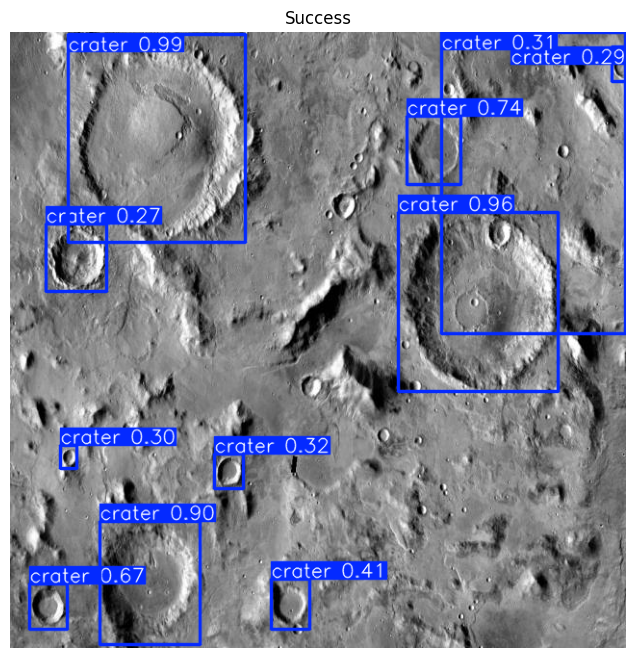

In [17]:
# Load your trained YOLOv11 model
yolo_model = YOLO('/content/drive/MyDrive/crater_detection/yolo11_crater_detection/weights/best.pt')

# Load the planetary surface classifier
with open('/content/planetary_classifier.pkl', 'rb') as f:
    surface_classifier = pickle.load(f)

# Test on a planetary image
print("Upload a planetary surface image to test:")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
result_img, status = process_image(test_image_path, yolo_model, surface_classifier)

# Display the result
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(status)
plt.show()

In [19]:
# Create directory in Google Drive if it doesn't exist
!mkdir -p /content/drive/MyDrive/crater_detection

# Save models to Google Drive
!cp /content/drive/MyDrive/crater_detection/yolo11_crater_detection/weights/best.pt /content/drive/MyDrive/crater_detection/
!cp /content/drive/MyDrive/crater_detection/yolo11_crater_detection/weights/best.onnx /content/drive/MyDrive/crater_detection/
!cp /content/planetary_classifier.pkl /content/drive/MyDrive/crater_detection/

# Download models locally
files.download('/content/drive/MyDrive/crater_detection/yolo11_crater_detection/weights/best.pt')
files.download('/content/drive/MyDrive/crater_detection/yolo11_crater_detection/weights/best.onnx')
files.download('/content/planetary_classifier.pkl')

print("Models saved successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Models saved successfully!
